## [Bayesian Regression - Introduction](http://pyro.ai/examples/bayesian_regression.html#Bayesian-Regression---Introduction-(Part-1))

In [ ]:
import os

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import torch
import pyro

In [ ]:
from functools import partial

In [ ]:
import pyro.distributions as dist

In [ ]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [ ]:
from torch import nn
from pyro.nn import PyroModule

In [ ]:
assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [ ]:
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]

data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

In [ ]:
x_data.shape

In [ ]:
y_data.shape

In [ ]:
lr_model = PyroModule[nn.Linear](3,1)

In [ ]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(lr_model.parameters(), lr=0.05)
num_iterations = 1500

In [ ]:
def train():
    y_pred = lr_model(x_data).squeeze(-1)
    loss = loss_fn(y_pred, y_data)
    optim.zero_grad()
    loss.backward()
    optim.step()
    return loss

In [ ]:
for j in range(num_iterations):
    loss = train()
    if (j+1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j+1, loss.item()))

In [ ]:
fit = df.copy()
fit["mean"] = lr_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

### Bayesian Regression Model

In [ ]:
from pyro.nn import PyroSample

In [ ]:
class BR(PyroModule):
    def __init__(self, in_features, out_target):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_target)
        # The BayesianRegression module internally uses the same PyroModule[nn.Linear] module. 
        # However, note that we replace the weight and the bias of the this module with PyroSample statements. 
        # These statements allow us to place a prior over the weight and bias parameters, 
        # instead of treating them as fixed learnable parameters. For the bias component, 
        # we set a reasonably wide prior since it is likely to be substantially above 0.
        self.linear.weight = PyroSample(dist.Normal(0.0,1.).expand([out_target, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_target]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0.,10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            # we use the obs argument to the pyro.sample statement to condition on the observed data y_data 
            # with a learned observation noise sigma
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

 Gaussian with diagonal covariance, i.e. it assumes that there is no correlation amongst the latent variables (quite a strong modeling assumption as we shall see i

In [ ]:
from pyro.infer.autoguide import AutoDiagonalNormal

In [ ]:
model = BR(3,1)
guide = AutoDiagonalNormal(model)

In [ ]:
from pyro.infer import SVI, Trace_ELBO

In [ ]:
adam = pyro.optim.Adam({"lr":0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [ ]:
pyro.clear_param_store()

for j in range(1000):
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j+1, loss / (len(data))))

In [ ]:
guide.requires_grad_(False)

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

In [ ]:
guide.quantiles([0.25, 0.5, 0.75])

### Model Evaluation

In [ ]:
from pyro.infer import Predictive

In [ ]:
preds =  Predictive(model, guide=guide, num_samples=800, return_sites=("linear.weight", 'obs',"_RETURN"))
samples = preds(x_data)

In [ ]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v,0),
            "std": torch.std(v,0),
            "5%": v.kthvalue(int(len(v)*0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v)*0.95), dim=0)[0],            
        }
    return site_stats

In [ ]:
pred_summary = summary(samples)

In [ ]:
mu = pred_summary['_RETURN']
y = pred_summary["obs"]

predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])

fig.suptitle("Regression line 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])

ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5) 

ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")     

ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");     

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])

ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)

ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")

ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [ ]:
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)

In [ ]:
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]

/home/dulunche/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dulunche/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


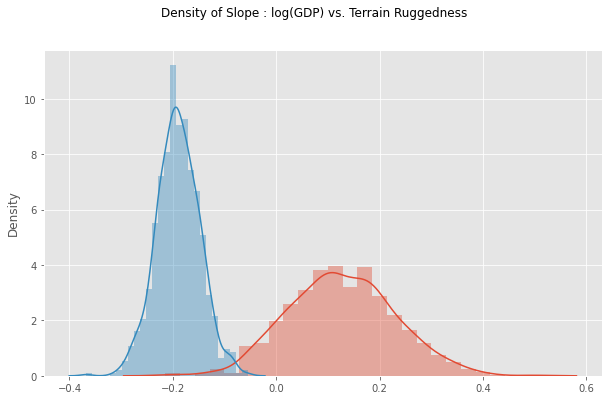

In [104]:
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

## Model Serving via TorchScript

Finally, note that the model, guide and the Predictive utility class are all torch.nn.Module instances, and can be serialized as TorchScript.

In [ ]:
from collections import defaultdict
from pyro import poutine
from pyro.poutine.util import prune_subsample_sites
import warnings

In [ ]:
class Predict(torch.nn.Module):
    def __init__(self, model, guide) -> None:
        super().__init__()
        self.model = model
        self.guide = guide

    def forward(self, *args, **kwargs):
        samples = {}
        guide_trace = poutine.trace(self.guide).get_trace(*args, **kwargs)
        model_trace = poutine.trace(poutine.replay(self.model, guide_trace)).get_trace(*args, **kwargs)
        for site in prune_subsample_sites(model_trace).stochastic_nodes:
            samples[site] = model_trace.nodes[site]['value']
        return tuple(v for _, v in sorted(samples.items()))

In [ ]:
predict_fn = Predict(model, guide)

In [ ]:
predict_module = torch.jit.trace_module(predict_fn, {"forward": (x_data,)}, check_trace=False)

In [ ]:
torch.jit.save(predict_module, '/tmp/reg_predict.pt')
pred_loaded = torch.jit.load('/tmp/reg_predict.pt')

In [ ]:
pred_loaded(x_data)[1]

In [ ]:
weight = []
for _ in range(800):
    # index = 1 corresponds to "linear.weight"
    weight.append(pred_loaded(x_data)[1])

In [ ]:
weight = torch.stack(weight).detach()

In [ ]:
weight.shape

In [ ]:
weight = weight.reshape(weight.shape[0], 3)

In [ ]:
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Loaded TorchScript Module : log(GDP) vs. Terrain Ruggedness");

___

## [Bayesian Regression - Inference Algorithms](http://pyro.ai/examples/bayesian_regression_ii.html#Bayesian-Regression---Inference-Algorithms-(Part-2))

In [ ]:
import logging
import os

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.optim as optim

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.8.2')

In [ ]:
%matplotlib inline
plt.style.use('ggplot')

logging.basicConfig(format='%(message)s', level=logging.INFO)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

We will write out the model again, similar to that in Part I, but explicitly without the use of PyroModule. We will write out each term in the regression, using the same priors. bA and bR are regression coefficients corresponding to is_cont_africa and ruggedness, a is the intercept, and bAR is the correlating factor between the two features.

In [74]:
def model(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR",  dist.Normal(0., 1.))

    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

In [73]:
def guide(is_cont_africa, ruggedness, log_gdp):
    a_loc = pyro.param("a_loc", torch.tensor(0.))
    a_scale = pyro.param("a_scale", torch.tensor(1.), constraint=constraints.positive)

    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.))

    weights_loc = pyro.param('weight_loc', torch.randn(3))
    weights_scale = pyro.param('weight_scale', torch.ones(3), constraint=constraints.positive)

    a = pyro.sample('a', dist.Normal(a_loc, a_scale))
    b_a = pyro.sample('bA', dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample('bR', dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample('bAR', dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample('sigma', dist.Normal(sigma_loc, torch.tensor(0.05)))

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

In [75]:
from pyro.infer import SVI, Trace_ELBO

In [82]:
svi = SVI(
            model,
            guide,
            optim.Adam({'lr':.05}),
            loss = Trace_ELBO()
        )

In [83]:
df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)

In [84]:
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

In [85]:
for i in range(5000):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 100 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 249.06645315885544
Elbo loss: 254.36201137304306
Elbo loss: 248.87554228305817
Elbo loss: 249.14888381958008
Elbo loss: 253.29344773292542
Elbo loss: 249.99251836538315
Elbo loss: 249.73704290390015
Elbo loss: 247.73264610767365
Elbo loss: 248.02887278795242
Elbo loss: 254.65117114782333
Elbo loss: 251.92083489894867
Elbo loss: 252.5244866013527
Elbo loss: 248.72071301937103
Elbo loss: 247.3404462337494
Elbo loss: 245.7253846526146
Elbo loss: 253.33128076791763
Elbo loss: 250.6410652399063
Elbo loss: 247.53854709863663
Elbo loss: 250.32618063688278
Elbo loss: 251.402341902256
Elbo loss: 269.63568341732025
Elbo loss: 248.32193529605865
Elbo loss: 249.14357209205627
Elbo loss: 247.85321283340454
Elbo loss: 260.4232800602913
Elbo loss: 249.96542197465897
Elbo loss: 250.17441076040268
Elbo loss: 251.73187470436096
Elbo loss: 247.8266830444336
Elbo loss: 248.90910017490387
Elbo loss: 250.4212390780449
Elbo loss: 245.58370286226273
Elbo loss: 249.8307431936264
Elbo loss: 249.17269

In [86]:
from pyro.infer import Predictive

In [87]:
number_samples = 1000

In [88]:
predictive = Predictive(model, guide=guide, num_samples= number_samples)

In [90]:
svi_samples = {
                k: v.reshape(number_samples).detach().cpu().numpy() 
                        for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
                        if k != "obs"
}

In [91]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [92]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%       50%     75%      95%
0  9.179585  0.085269  9.040073  9.118157  9.179277  9.2363  9.31517 

Site: bA
       mean       std        5%       25%       50%       75%       95%
0 -1.828315  0.138962 -2.057125 -1.923956 -1.829951 -1.731582 -1.601511 

Site: bR
       mean      std        5%       25%       50%       75%       95%
0 -0.163171  0.04219 -0.231776 -0.192028 -0.164414 -0.134547 -0.094058 

Site: bAR
       mean       std        5%       25%       50%      75%       95%
0  0.392302  0.083753  0.261466  0.332688  0.390905  0.44589  0.533471 

Site: sigma
       mean       std      5%       25%       50%       75%       95%
0  0.974554  0.049388  0.8912  0.942272  0.975652  1.006961  1.056704 



___

### HMC

In [93]:
from pyro.infer import MCMC, NUTS

In [94]:
nuts_kernel = NUTS(model)

In [98]:
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)

In [100]:
mcmc.run(is_cont_africa, ruggedness, log_gdp)

Sample: 100%|██████████| 1200/1200 [00:24, 49.94it/s, step size=4.85e-01, acc. prob=0.921]


In [101]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [102]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%       50%       75%       95%
0  9.173776  0.132256  8.960975  9.083566  9.175395  9.254833  9.393378 

Site: bA
       mean       std        5%       25%      50%       75%      95%
0 -1.825052  0.210715 -2.163132 -1.971019 -1.82404 -1.686269 -1.46138 

Site: bAR
       mean       std        5%       25%       50%       75%       95%
0  0.337638  0.126396  0.126745  0.247859  0.340764  0.423111  0.542548 

Site: bR
       mean       std        5%       25%       50%       75%       95%
0 -0.178255  0.072478 -0.298132 -0.225458 -0.177767 -0.130754 -0.063311 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.951042  0.050663  0.870264  0.916096  0.948907  0.983295  1.037213 



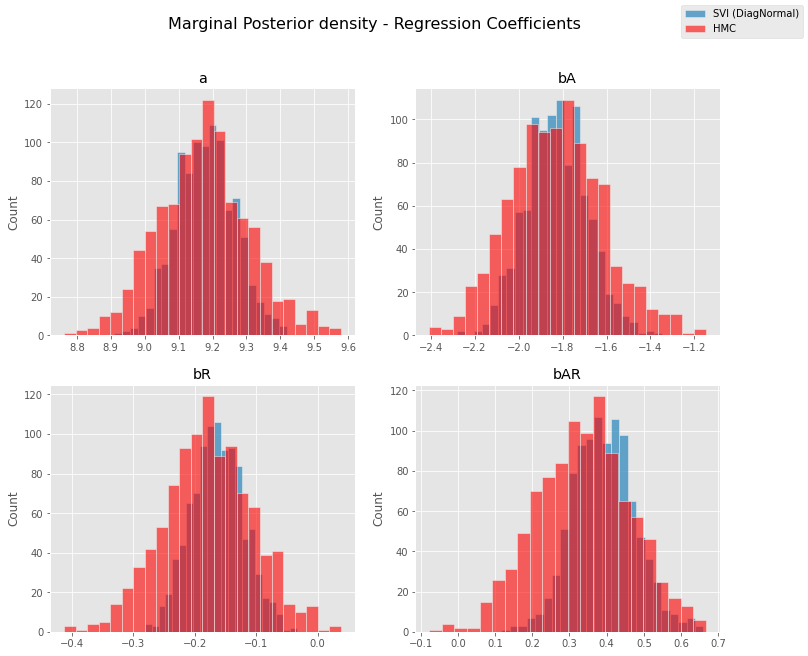

In [108]:
sites = ["a", "bA", "bR", "bAR", "sigma"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.histplot(svi_samples[site], ax=ax, label="SVI (DiagNormal)")
    sns.histplot(hmc_samples[site], ax=ax, color="red", alpha=0.6 ,label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

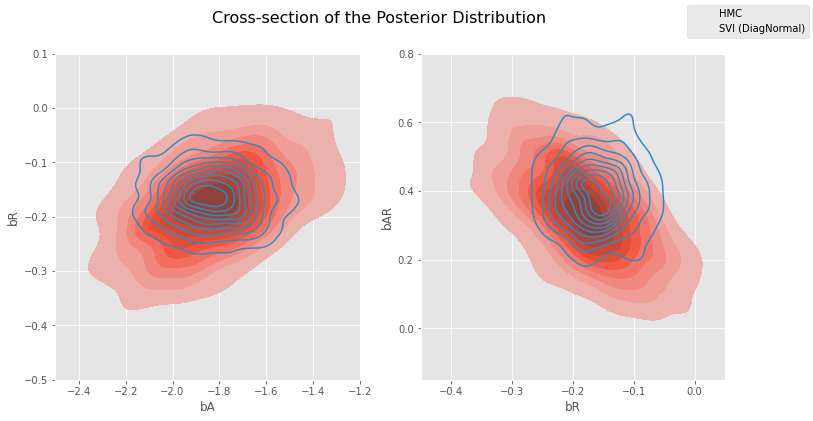

In [109]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=hmc_samples["bA"], y=hmc_samples["bR"], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(x=svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], label="SVI (DiagNormal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(x=hmc_samples["bR"], y=hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(x=svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1], label="SVI (DiagNormal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

This can be better seen when we plot different cross sections from the joint posterior distribution overlaid with the approximate posterior from variational inference. Note that since our variational family has diagonal covariance, we **cannot model any correlation between the latents** and the resulting approximation is overconfident (under-dispersed)